## CS 401 Applied Data Analysis, 2018 autumn
## Final Project: Exploration on Media polarity in the News
##### Group Members: Ruibin Huang, Liangwei Chen, Fengyu Cai

### Objective:
In this project, we would like to dig up the potential media polarity about the news on the websites. Through the year, we hope to find out the bias for some media as to some specific topics.

### Main Step
- Label the news with keywords or topic
    - TF-IDF
- Select specific news and medias for analysis in the similar time and topic
    - NLTK sentiment analysis package
- Further analyze based on the chronological and geometrical features of the medias
    - map or plot

Technologies applied (and will be applied): spark, Machine Learning, NLTK, Web Crawling

### About Datasets:
1. News Source: containing News IDs, Publisher, Publish Date, Publish Region, Publish Organization, News URL and News Title
2. News Excerpt: containing excerpts of website HTML, responding to the NEWs ID.
3. News parse and stemming: containing the canonical steming form of the news, which is convenient for manipulation and search.

### Milestone Summary:
In this milestone, we will do the analysis based on a limited data set: news on the website mainly during October in 2016 in the United States.
1. From News parse and stemming file, we applied TF-IDF to choose the linguitics keyword as document feature.
2. From the keywords set, we select some meaningful topic as our target.
3. For the document in selected documents, check whether there exist sentimental bias in this document, taking advantage of NLTK sentimental analysis.

In [1]:
# Import Module
import sys
import os
import re
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import string
import gc
import pickle
import matplotlib.pyplot as plt

### Part 1: Data Preprocessing

In [2]:
# data path
stm_file = '16-10-us.txt'
alter_file = '16-10-us-clean.txt'
src_file = 'now_sources_pt2.txt'
src_folder = 'source'

##### 1.1 Stemming File Clean:
As we find in the News Stemming File, there exits some illegal characters, therefore, we need to filter to get the pure data.

1.1.1 Encoding Issue

In [3]:
# remove the punctuations in the text
with open(stm_file, 'r', errors='replace', encoding='utf-8') as f:
    with open(alter_file ,'w') as w:
        w.write(re.sub('\t[' + string.punctuation + ']\t', '\tN/A\t', f.read()))

1.1.2 Select the write format data

In [4]:
id_c = re.compile(r'\d+')
def getId(line):
    return id_c.match(line).group(0)

In [115]:
colnames=['doc_id', 'word_id', 'word', 'origin_word', 'pos'] 
stemming_pd = pd.read_csv(alter_file, sep='\t', error_bad_lines=False, engine='python', header=None, names=colnames)

In [6]:
stemming_pd.head(10)

,doc_id,word_id,word,origin_word,pos
0,14637197,4739839025,@@14637197,NaN,fo
1,14637197,4739839026,<p>,NaN,null
2,14637197,4739839027,NEW,new,np1
3,14637197,4739839028,YORK,york,np1
4,14637197,4739839029,NaN,NaN,(
5,14637197,4739839030,AP,ap,np1
6,14637197,4739839031,NaN,NaN,)
7,14637197,4739839032,--,NaN,jj_nn1
8,14637197,4739839033,Donald,donald,np1
9,14637197,4739839034,Trump,trump,nn1


In [7]:
stemming_pd.dropna(inplace=True)

In [8]:
# after drop NA
stemming_pd.head(10)

,doc_id,word_id,word,origin_word,pos
2,14637197,4739839027,NEW,new,np1
3,14637197,4739839028,YORK,york,np1
5,14637197,4739839030,AP,ap,np1
8,14637197,4739839033,Donald,donald,np1
9,14637197,4739839034,Trump,trump,nn1
10,14637197,4739839035,'s,'s,ge
11,14637197,4739839036,five-day,five-day,jj
12,14637197,4739839037,feud,feud,nn1
13,14637197,4739839038,with,with,iw
14,14637197,4739839039,a,a,at1


In [9]:
stemming_list = stemming_pd.groupby('doc_id')['origin_word'].apply(list).apply(lambda x: ' '.join(x))

In [10]:
pd.DataFrame(stemming_list).head()

,origin_word
doc_id,
14637197,new york ap donald trump 's five-day feud with...
14637200,here be all the crazy stuff that happen at the...
14637201,another hotel want to build in the heart of ho...
14637202,in this sept 23 2016 photo rick retail sales m...
14637203,court erase jury award of punitive damage agai...


##### 1.2 Load the data Source

1.2.1 load new source data

In [11]:
new_src = pd.read_csv(os.path.join(src_folder, src_file), delimiter="\t", header=None, encoding = "ISO-8859-1")

In [12]:
new_src.columns=['id','unknown','date','country','media','website','title']

In [13]:
new_src.head(10)

,id,unknown,date,country,media,website,title
0,2930853,194,15-01-01,US,Consequence of Sound,http://consequenceofsound.net/2015/01/100000-c...,100000 copies of The Interview will be dropped...
1,2930854,266,15-01-01,US,Los Angeles Times,http://www.latimes.com/entertainment/movies/la...,'The Taking of Tiger Mountain' gets blockbuste...
2,2930855,701,15-01-01,US,TIME,http://time.com/3651697/afghanistan-war-cost/,The True Cost of the Afghanistan War May Surpr...
3,2930856,1963,15-01-01,US,The Week Magazine,http://theweek.com/articles/441310/confessions...,Confessions of a former TSA officer
4,2930859,263,15-01-01,US,Russia Beyond the Headlines,http://rbth.com/arts/2015/01/01/year_of_litera...,"Pushkin, Gogol and Akhmatova to be symbols of ..."
5,2930864,199,15-01-01,US,Quartz,http://qz.com/320207/piketty-rejects-legion-of...,"Piketty rejects Legion of Honor, vindicates Na..."
6,2930865,3740,15-01-01,US,The Atlantic,http://www.theatlantic.com/national/archive/20...,New York's Unfinished Tale of Two Cities
7,2930866,437,15-01-01,US,New York Times,http://www.nytimes.com/roomfordebate/2015/01/0...,Reaching the American Dream Is Harder for Peop...
8,2930867,896,15-01-01,US,CNBC,http://www.cnbc.com/2014/12/31/the-rise-of-the...,The rise of the do-it-yourself consumer
9,2930868,1913,15-01-01,US,KQED,http://ww2.kqed.org/news/2015/01/01/the-most-i...,The Most Important New California Laws of 2015


In [14]:
new_src['year'], new_src['month'], new_src['day'] = new_src['date'].str.split('-', 2).str

In [15]:
new_src.head()

,id,unknown,date,country,media,website,title,year,month,day
0,2930853,194,15-01-01,US,Consequence of Sound,http://consequenceofsound.net/2015/01/100000-c...,100000 copies of The Interview will be dropped...,15,01,01
1,2930854,266,15-01-01,US,Los Angeles Times,http://www.latimes.com/entertainment/movies/la...,'The Taking of Tiger Mountain' gets blockbuste...,15,01,01
2,2930855,701,15-01-01,US,TIME,http://time.com/3651697/afghanistan-war-cost/,The True Cost of the Afghanistan War May Surpr...,15,01,01
3,2930856,1963,15-01-01,US,The Week Magazine,http://theweek.com/articles/441310/confessions...,Confessions of a former TSA officer,15,01,01
4,2930859,263,15-01-01,US,Russia Beyond the Headlines,http://rbth.com/arts/2015/01/01/year_of_litera...,"Pushkin, Gogol and Akhmatova to be symbols of ...",15,01,01


In [16]:
new_src_us = new_src[new_src['country']=='US']

In [20]:
new_src_us.head(5)

,id,unknown,date,country,media,website,title,year,month,day
0,2930853,194,15-01-01,US,Consequence of Sound,http://consequenceofsound.net/2015/01/100000-c...,100000 copies of The Interview will be dropped...,15,01,01
1,2930854,266,15-01-01,US,Los Angeles Times,http://www.latimes.com/entertainment/movies/la...,'The Taking of Tiger Mountain' gets blockbuste...,15,01,01
2,2930855,701,15-01-01,US,TIME,http://time.com/3651697/afghanistan-war-cost/,The True Cost of the Afghanistan War May Surpr...,15,01,01
3,2930856,1963,15-01-01,US,The Week Magazine,http://theweek.com/articles/441310/confessions...,Confessions of a former TSA officer,15,01,01
4,2930859,263,15-01-01,US,Russia Beyond the Headlines,http://rbth.com/arts/2015/01/01/year_of_litera...,"Pushkin, Gogol and Akhmatova to be symbols of ...",15,01,01


In [18]:
data_US_16_10 = new_src_us[(new_src_us['year']=='16') & (new_src_us['month']=='10')]

In [27]:
data_US_16_10_sorted = data_US_16_10.sort_values(by='id')

In [29]:
data_US_16_10_sorted.head()

,id,unknown,date,country,media,website,title,year,month,day
304572,14637197,170,16-10-01,US,Bristol Herald Courier (press release) (blog),http://www.heraldcourier.com/news/trump-s-habi...,Trump's habit of fuming over slights comes at ...,16,10,01
304573,14637200,411,16-10-01,US,CBSSports.com,http://www.cbssports.com/college-football/news...,Here's all the crazy stuff that happened at th...,16,10,01
304574,14637201,159,16-10-01,US,Curbed LA,http://la.curbed.com/2016/9/30/13128220/hollyw...,11 story hotel proposed for the heart of Holly...,16,10,01
304575,14637202,1998,16-10-01,US,The Bozeman Daily Chronicle,http://www.bozemandailychronicle.com/ap_news/m...,Biologists to measure impact of Yellowstone Ri...,16,10,01
304576,14637203,176,16-10-01,US,The Republic,http://www.therepublic.com/2016/10/01/az-motor...,Court erases jury award of punitive damages ag...,16,10,01


### Part 2: Topic Selection

After data processing, we step to the next step of topic selection. We will use the methods of TF-IDF, which has been embeded in skicit-learn.

In [30]:
# In the milestone, we only consider 1-gram in the tf-idf
countvec = CountVectorizer(stop_words='english', ngram_range=(1,1))
tfidfvec = TfidfTransformer()

In [31]:
text_list = list(stemming_list.values)
ind_list = list(stemming_list.keys())

In [32]:
word_freq = countvec.fit_transform(text_list)

In [34]:
# get the number of news and the number of 1-gram
num_doc, num_feat = word_freq.shape

In [50]:
# 1-gram words sorted in alphabetal order
features = countvec.get_feature_names()
features[10000:10010]

['burke',
 'burkett',
 'burkhardt',
 'burkholder',
 'burkina',
 'burkitt',
 'burkle',
 'burks',
 'burlap',
 'burleigh']

In [39]:
word_freq

<23055x65844 sparse matrix of type '<class 'numpy.int64'>'
	with 2365276 stored elements in Compressed Sparse Row format>

We find that the word freqency matrix is highly sparse.

In [45]:
# glance at the sparse matrix
pd.DataFrame(word_freq[0:10].toarray(), columns=countvec.get_feature_names())

,00,000,0000,000th,001,002,0023,003,004,005,...,zuzu,zverev,zvi,zweig,zwick,zwierlein,zwilling,zx,zygote,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# from sparse word frequency, calculate the tf-idf matrix
tfidf = tfidfvec.fit_transform(word_freq)

In [54]:
# get the entries with value in the sparse matrix
entries = tfidf.tolil().rows

In [70]:
# the keywords of the first docoment
pd.DataFrame(features).iloc[entries[0]].head(10)

,0
359,15
1109,30
3354,airing
4627,ap
5203,article
7081,beauty
9095,brag
9179,brash
10092,businessman
10499,campaign


In [158]:
# record the keyword index for each document
tfidf_matrix = [[(entries[doc][i], tfidf[doc].toarray()[0][entries[doc][i]]) for i in range(len(entries[doc]))] for doc in range(num_doc)]

In [162]:
# save the matrix to pickle
with open('tfidf.pickle', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

In [75]:
# load the pickle to tfidf-matrix
with open('tfidf.pickle', 'rb') as w:
    tfidf_matrix = pickle.load(w)

In [82]:
tfidf_top10 = [sorted(tfidf_matrix[i], key=lambda x: x[1], reverse=True)[:10] for i in range(num_doc)]

In [83]:
tfidf_top10_name = [[(features[x[0]], x[1]) for x in tfidf_top10[i]] for i in range(num_doc)]

In [92]:
# convert to pandas DataFrame
tfidf_top10_pd = pd.DataFrame(tfidf_top10_name, index=ind_list)
tfidf_top10_pd.index.name = 'Id'

In [93]:
tfidf_top10_pd.head()

,0,1,2,3,4,5,6,7,8,9
Id,,,,,,,,,,
14637197,"(article, 0.3231129513690259)","(entirety, 0.2510290164608949)","(online, 0.24465264706847722)","(need, 0.2234580095033969)","(subscription, 0.2170400061690015)","(service, 0.19894874553392955)","(confrontational, 0.1791444819081644)","(tenacity, 0.17376868493437247)","(brash, 0.16827200370669051)","(thirst, 0.167100838004032)"
14637200,"(toledo, 0.5006275298991661)","(byu, 0.2251267442257118)","(mack, 0.20236457207395567)","(woodside, 0.1817846776596635)","(game, 0.1708867364649886)","(broadcast, 0.13848178834439617)","(brown, 0.1312003993314338)","(grab, 0.13073268144047578)","(replay, 0.13036903363929486)","(ensuing, 0.12703707069285639)"
14637201,"(cahuenga, 0.3443785000085918)","(hollywood, 0.3316018473377978)","(hotel, 0.24975932711993432)","(project, 0.19498070640999493)","(parking, 0.18095834624622986)","(developer, 0.18047271513603777)","(plan, 0.16774698785252296)","(construction, 0.16458284194527986)","(334, 0.16066043091749754)","(palladium, 0.15135258208225924)"
14637202,"(river, 0.43741932617450596)","(whitefish, 0.41041669203250136)","(yellowstone, 0.35392258902672885)","(fish, 0.28701407869412077)","(biologist, 0.19724807594786847)","(angler, 0.16060113092124212)","(parasite, 0.15484113269919386)","(fishing, 0.14065077888172087)","(trout, 0.12981872039072806)","(rachel, 0.11717566543629883)"
14637203,"(punitive, 0.3455224429347211)","(newsgathering, 0.2737209523650647)","(motorcyclist, 0.2466180682188501)","(claim, 0.22002071797655545)","(erase, 0.2046431001293423)","(insurer, 0.20416982741935266)","(standard, 0.20136157039367233)","(damage, 0.1928329657221136)","(ruling, 0.1713627098884841)","(court, 0.1687594859435715)"


In [94]:
tfidf_top10_Nameset = [x[0] for i in range(num_doc) for x in tfidf_top10_name[i]]

In [96]:
tfidf_top5_key = [[x[0] for x in tfidf_top10_name[i]] for i in range(num_doc)]

In [97]:
from collections import Counter
cnt = Counter(tfidf_top10_Nameset)

In [105]:
key_words_pd = pd.DataFrame(pd.Series(dict(cnt)), columns=['Frequency'])

In [107]:
key_words_top20 = key_words_pd.sort_values(by='Frequency', ascending=False).iloc[:20]
key_words_top20.index.name = 'Keywords'

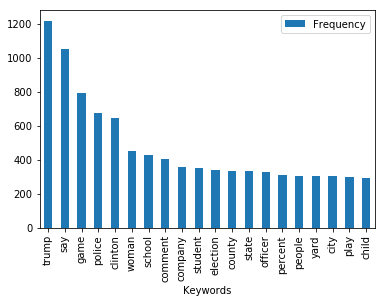

In [112]:
key_words_top20.plot(kind='bar')
plt.show()

In [114]:
key_words_top20.head()

,Frequency
Keywords,
trump,1219
say,1049
game,792
police,676
clinton,648


### Discovery:
After our tfidf analysis, we could find out that in the month rightly before American Precidental Election, the high-frequent keywords are related to this topic.

In [211]:
trump_list = [ind_list[i] for i in range(num_doc) if 'trump' in tfidf_top5_key[i]]

In [216]:
with open('trump_list.pickle', 'wb') as w:
    pickle.dump(trump_list, w)

### Part3: Get Original Data from Website

In [18]:
from bs4 import BeautifulSoup
import requests

In [98]:
url = data_US_16_10['website'].iloc[1]

In [99]:
r = requests.get(url)

In [100]:
soup = BeautifulSoup(r.text, 'html.parser')

In [101]:
txt = ''
tags = r'\<.*\>'
tags_re = re.compile(tags)

In [102]:
tags_re.sub('', str(soup.p))

''

In [103]:
a = soup.p

In [104]:
while a:
#     print(a)
    t = tags_re.sub('', str(a))
    print(t)
    txt += t
    a = a.next



By 

Amid Amidi
 | 

10/01/2016 8:42 pm
 | 



6 Comments





























































































































Share






















Tweet






















Email







6
 





























Journey into the deepest, darkest corners of Rio de Janeiro in the teaser for the anime-influenced Brazilian/French animated feature 

Heart of Darkness
:














The proposed film transplants Joseph Conrad’s classic novel of the same name from Africa to a “near future” Rio. Here’s the official synopsis:




Marlow is a young police officer whose mission is to find and capture a certain Captain Kurtz, legendary member of the police who deserted the corporation and maintains a rebellious society in an almost inaccessible place in the suburbs of Rio de Janeiro. Marlow will have to fulfill his mission in a small boat, undertaking a dangerous journey, navigating precariously the mangrove channels, thro

In [97]:
re.sub('\s+', ' ', txt)

' Sport: SoccerEvent: Charlotte InvitationalCoach: Keith DrittlerNews: The 15-member team went a perfect 4-0 and defeated the CSA Matthews Predators 2-0 in the finals to win its age division of the annual Charlotte Invitational Tournament. Leading up to the finale, the local squad upended ACS Orange (3-0), CSA North Cab-Copa (5-0) and the Predators (2-0).Team members: Hannah Bogans, Shelbie Bohensky, Rachel Branson, Katie Drittler, Olivia Filimonczuk, Lindsay Hunt, Ryleigh Kennedy, Brianna Leckie, Maria Lum, Addie Robertson, Lindsay Seldal, Brooke Shavers, Emma Snider, Megan Snider and Kayle Stevenson.Note: Each year the Charlotte Youth Soccer Academy welcomes girls and boys teams ranging in age from U9-U18 to participate in their annual Dick\'s Sporting Goods Invitational Tournament. Savannah United executive director Gary Wright stated the annual event is the premier preseason kickoff for area teams. The Charlotte organization has been hosting squads from the USYS, US Club and AYSO f

In [105]:
url

'http://www.cartoonbrew.com/feature-film/watch-teaser-trailer-gritty-brazilian-take-heart-darkness-143606.html'